In [1]:
import os
import json
import numpy as np
import torch as th
import motornet as mn
import pickle
import matplotlib.pyplot as plt

from my_policy import Policy  # the RNN
from my_task import CentreOutFF  # the task
from my_loss import cal_loss  # the loss function
from my_utils import (
    save_model,
    print_losses,
    plot_stuff,
    run_episode,
    test,
    plot_training_log,
    plot_simulations,
    plot_activation,
    plot_kinematics,
)  # utility functions
print("All packages imported.")
print("pytorch version: " + th.__version__)
print("numpy version: " + np.__version__)
print("motornet version: " + mn.__version__)

All packages imported.
pytorch version: 2.5.1
numpy version: 2.1.3
motornet version: 0.2.0


In [2]:
model_name = "m0"
data = test(
        "models/" + model_name + "/" + model_name + "_cfg.json",
        "models/" + model_name + "/" + model_name + "_weights",
    )[0]
print(data.keys())

dict_keys(['xy', 'obs', 'tg', 'vel', 'all_actions', 'all_hidden', 'all_muscle', 'all_force'])


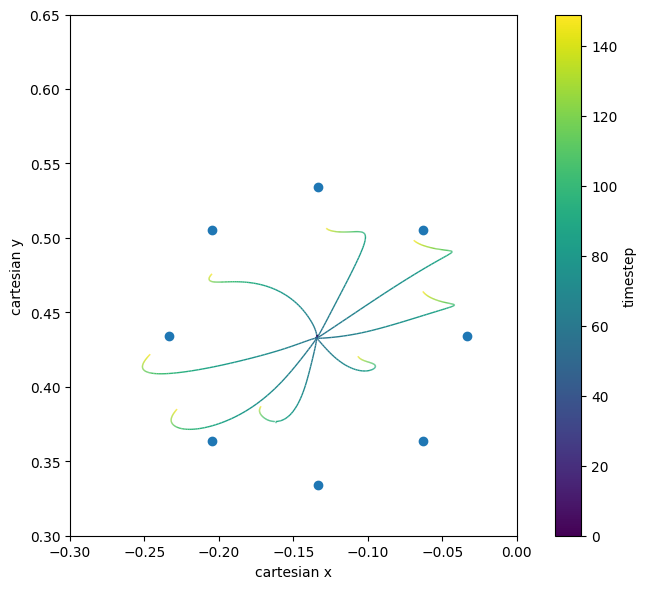

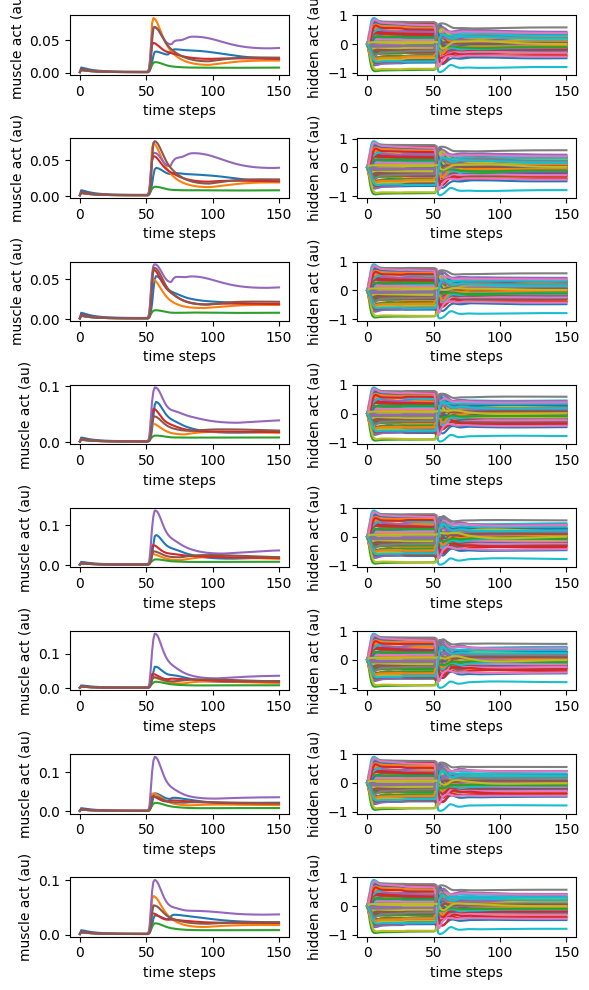

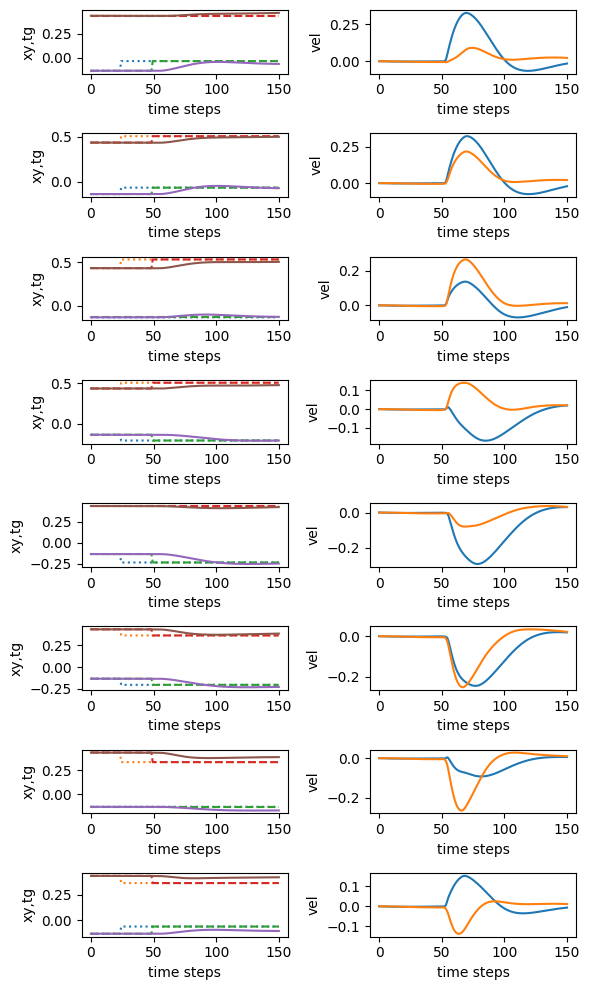

In [3]:
fig, ax = plot_simulations(xy=data["xy"], target_xy=data["tg"], figsize=(8, 6))
fig, ax = plot_activation(data["all_hidden"], data["all_muscle"])
fig, ax = plot_kinematics(all_xy=data["xy"], all_tg=data["tg"], all_vel=data["vel"], all_obs=data["obs"])

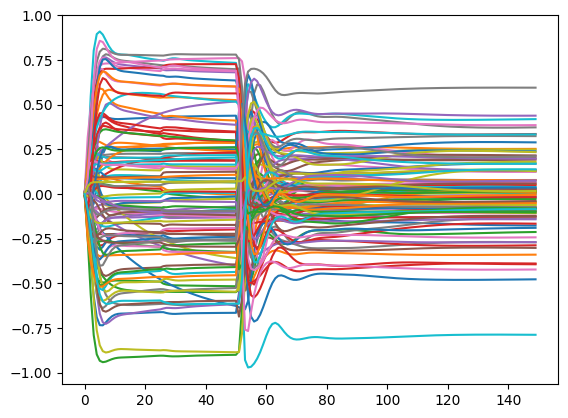

In [19]:
plt.plot(data["all_hidden"][2,:,:])
plt.show()